Ingesta de datos y preprocesamiento
Análisis exploratorio
Modelado predictivo
Diseño de aplicación (Streamlit)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import plotly_express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier



# Carga de Datos

In [26]:
spotify2024 = pd.read_csv('/Users/aguedagambon/Bootcamp/Temario/Modulo_3/Proyecto_Spotify/spotify-2024.csv', encoding='latin1')

In [27]:
spotify2024.head()

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1


In [28]:
spotify2024.shape

(4600, 29)

In [29]:
print(spotify2024.shape)

(4600, 29)


# Limpieza de datos

### Nulos

In [30]:
spotify2024.isnull().sum()

Track                            0
Album Name                       0
Artist                           5
Release Date                     0
ISRC                             0
All Time Rank                    0
Track Score                      0
Spotify Streams                113
Spotify Playlist Count          70
Spotify Playlist Reach          72
Spotify Popularity             804
YouTube Views                  308
YouTube Likes                  315
TikTok Posts                  1173
TikTok Likes                   980
TikTok Views                   981
YouTube Playlist Reach        1009
Apple Music Playlist Count     561
AirPlay Spins                  498
SiriusXM Spins                2123
Deezer Playlist Count          921
Deezer Playlist Reach          928
Amazon Playlist Count         1055
Pandora Streams               1106
Pandora Track Stations        1268
Soundcloud Streams            3333
Shazam Counts                  577
TIDAL Popularity              4600
Explicit Track      

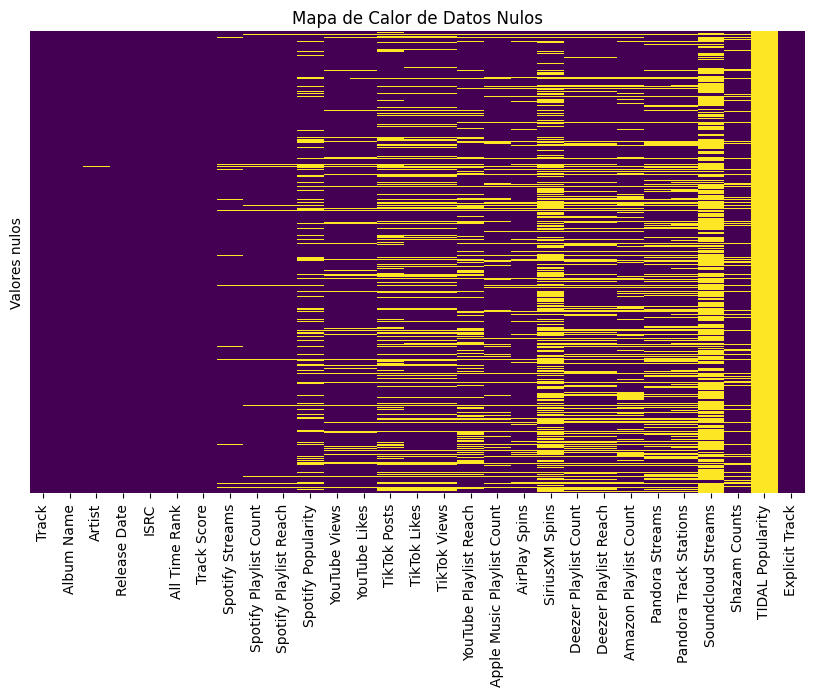

In [31]:
plt.figure(figsize=(10, 6))  
sns.heatmap(spotify2024.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Mapa de Calor de Datos Nulos')
plt.ylabel('Valores nulos')

plt.show()  

In [32]:
spotify2024 = spotify2024.drop(columns=['TIDAL Popularity'])

In [33]:
#Convertir columnas de tipo 'object' a numérico a partir de la sexta columna (donde comienzan las variables numericas)
for column in spotify2024.columns[5:]:
    if spotify2024[column].dtype == 'object':
        spotify2024[column] = spotify2024[column].str.replace(',', '') 
        spotify2024[column] = pd.to_numeric(spotify2024[column], errors='coerce')

In [34]:
spotify2024['Release Date'] = pd.to_datetime(spotify2024['Release Date'])

En este gráfico de distribución vemos que solo Spotify Popularity sigue una distribución normal, por lo que limpiamos los datos de la sigueitne forma:

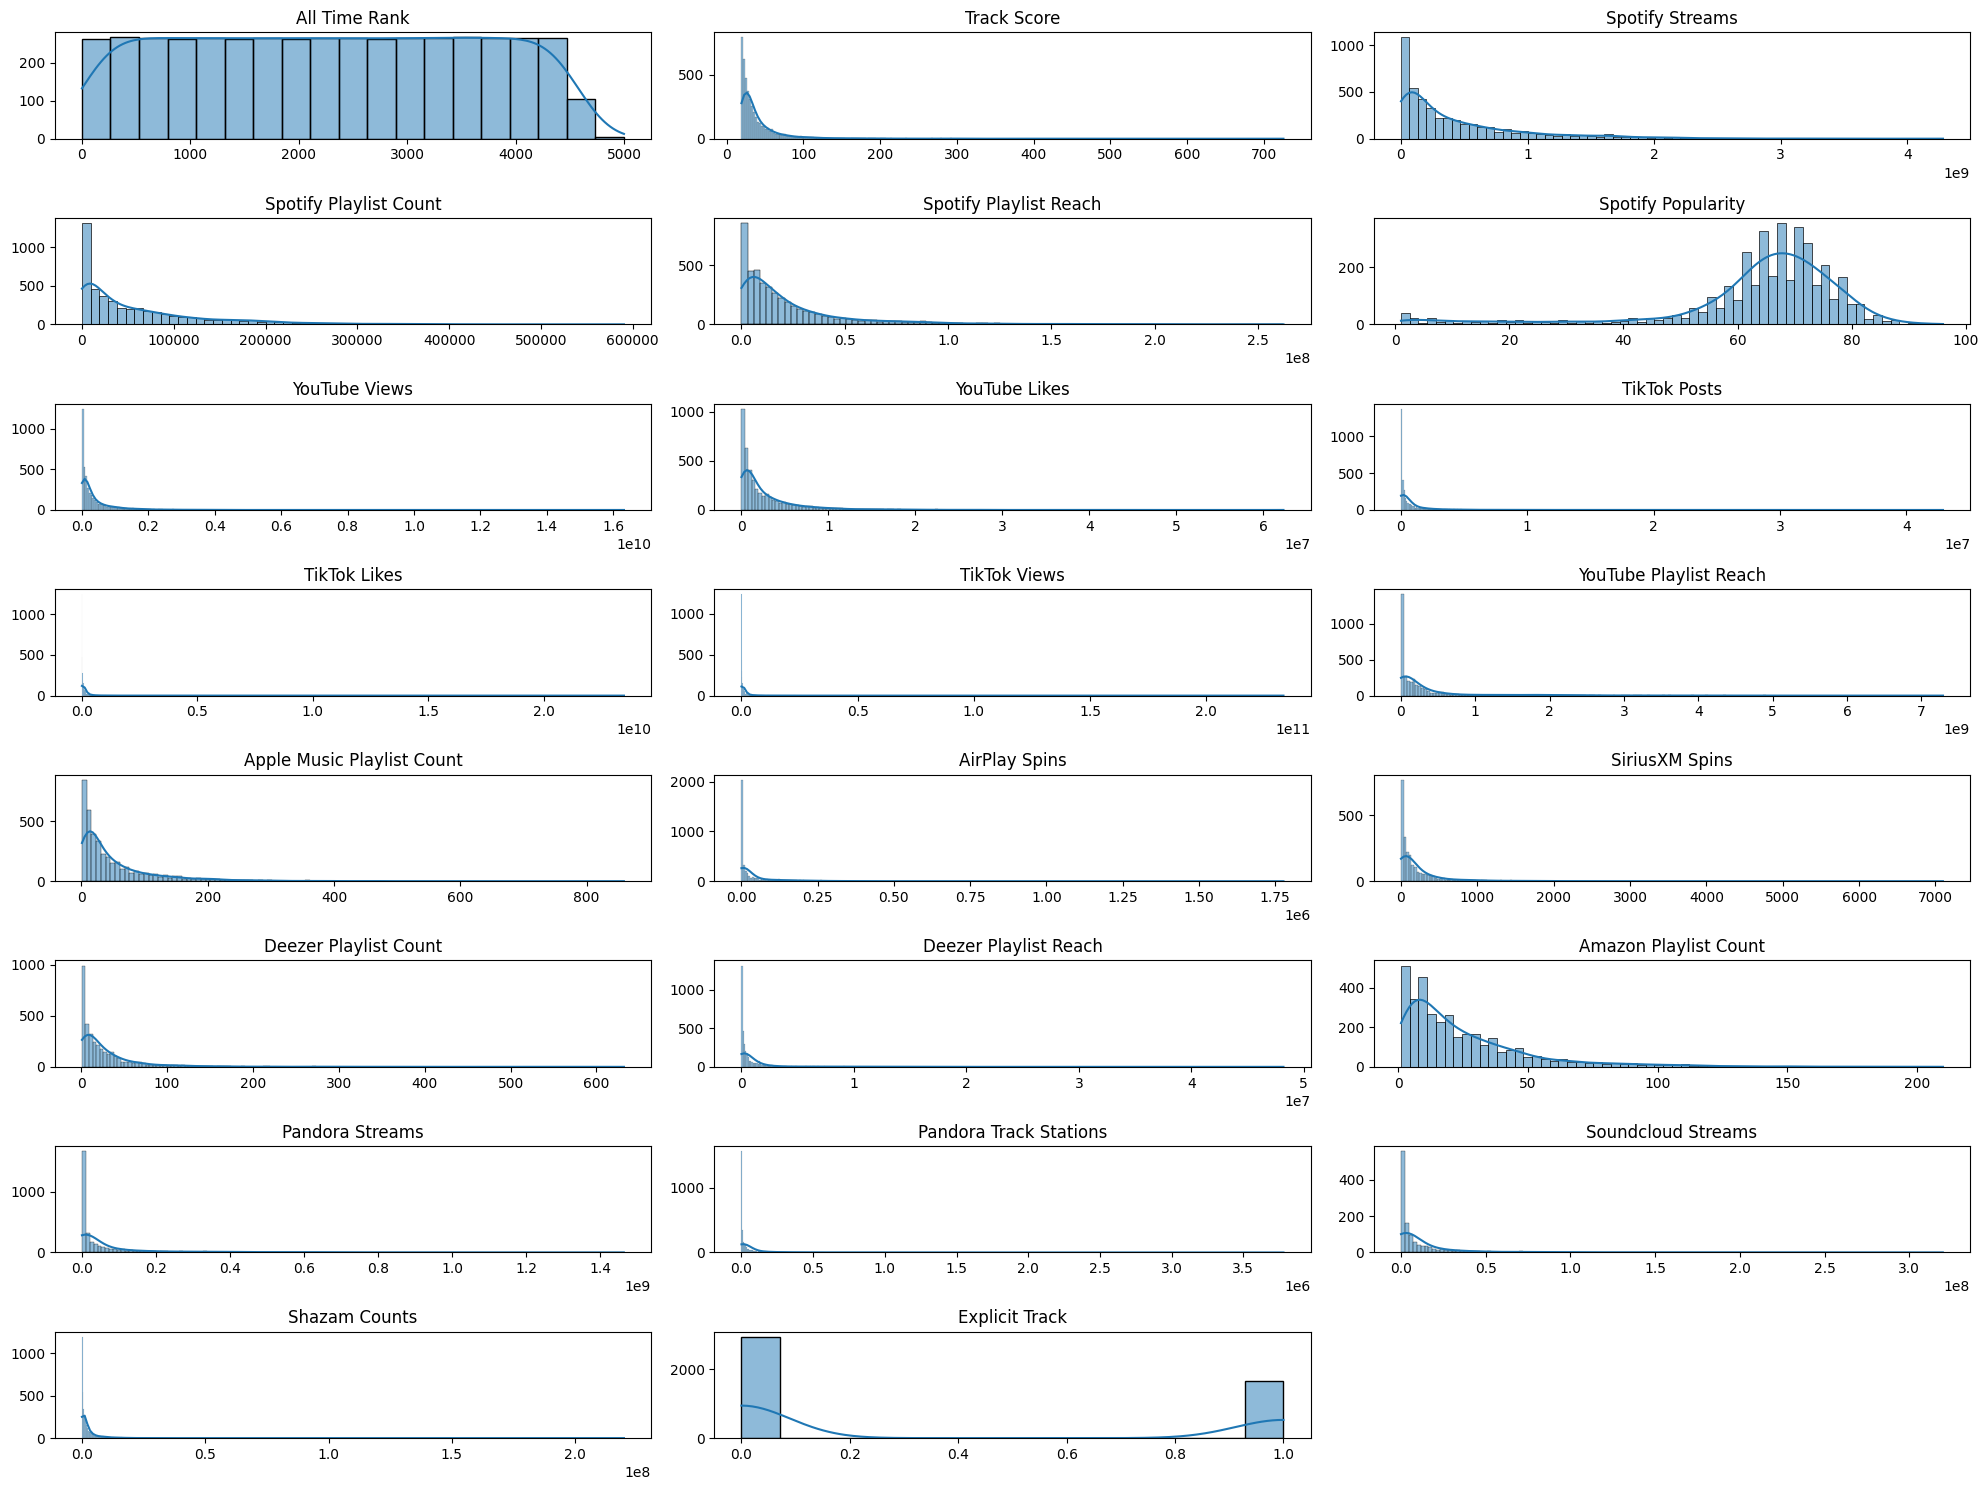

In [35]:
# Distribución de las variables numéricas en el dataset
numeric_data = spotify2024.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(20, 15))

for i, column in enumerate(numeric_data.columns, 1):
    plt.subplot((len(numeric_data.columns) // 3) + 1, 3, i)
    sns.histplot(numeric_data[column].dropna(), kde=True)
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


In [36]:
#Para la columna Artist, al ser un string, reemplazo los valores nulos por 'Desconocido'
spotify2024['Artist'].fillna('desconocido', inplace=True)

In [37]:
#Dado que solo Spotify Popularity es una distribución normal, substituiré los valores nulos con la media.
spotify2024['Spotify Popularity'].fillna(spotify2024['Spotify Popularity'].mean(), inplace=True)

In [38]:
#Para el resto de columnas numericas, reemplazo los valores nulos por la mediana al no ser distribuciones normales.
median_columns = [
    'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach',
    'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins',
    'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach',
    'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
    'Soundcloud Streams', 'Shazam Counts'
]

for column in median_columns:
    spotify2024[column].fillna(spotify2024[column].median(), inplace=True)

In [39]:
#Elimino filas duplicadas
spotify2024.drop_duplicates(inplace=True)

In [40]:
spotify2024.columns

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'Explicit Track'],
      dtype='object')

In [18]:
# Cambio la leyenda de NaN
spotify2024['Explicit Track'] = spotify2024['Explicit Track'].map({0: 'No explicita', 1: 'Explicita'})

In [19]:
print(spotify2024['Explicit Track'].unique())
print(spotify2024['Explicit Track'].dtype)

['No explicita' 'Explicita']
object


In [41]:
# Crear un diccionario para mapear los nombres antiguos a los nuevos
rename_dict = {col: col.replace('Playlist Count', 'Total Playlists') for col in spotify2024.columns if 'Playlist Count' in col}

# Renombrar las columnas usando el diccionario
spotify2024.rename(columns=rename_dict, inplace=True)

In [42]:
"""# Diccionario de traducción de nombres de columnas de inglés a español
traducciones = {
    'Artist': 'Artista',
    'Track': 'Canción',
    'Album Name': 'Nombre del Álbum',
    'Release Date': 'Fecha de Lanzamiento',
    'Popularity': 'Popularidad',
    'Spotify Streams': 'Reproducciones en Spotify',
    'Shazam Counts': 'Búsquedas en Shazam',
    'Explicit Track': 'Canción Explícita'
}

spotify2024.rename(columns=traducciones, inplace=True)"""

In [43]:
spotify2024.columns

Index(['Canción', 'Nombre del Álbum', 'Artista', 'Fecha de Lanzamiento',
       'ISRC', 'All Time Rank', 'Track Score', 'Reproducciones en Spotify',
       'Spotify Total Playlists', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Total Playlists', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Total Playlists', 'Deezer Playlist Reach',
       'Amazon Total Playlists', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Búsquedas en Shazam', 'Canción Explícita'],
      dtype='object')

In [ ]:
spotify2024.to_csv('/Users/aguedagambon/Bootcamp/Temario/Modulo_3/Proyecto_Spotify/spotify2024_traducido.csv', index=False)

### Análisis de Outliers

In [ ]:
#Calculo de outliers con función IQR en las columnas numericas
"""
numeric_columns = spotify2024.select_dtypes(include=['float64', 'int64']).columns

def calculate_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column < lower_bound) | (column > upper_bound)]


for column in numeric_columns:
    outliers = calculate_outliers_iqr(spotify2024[column])
    print(f"Outliers en la columna '{column}':")
    print(outliers)
    print(f"Cantidad de outliers en la columna '{column}': {outliers.count()}")
    print("\n")

"""

Outliers en la columna 'All Time Rank':
Series([], Name: All Time Rank, dtype: int64)
Cantidad de outliers en la columna 'All Time Rank': 0


Outliers en la columna 'Track Score':
0      725.4
1      545.9
2      538.4
3      444.9
4      423.3
       ...  
397     76.6
398     76.6
399     76.6
400     76.5
401     76.3
Name: Track Score, Length: 402, dtype: float64
Cantidad de outliers en la columna 'Track Score': 402


Outliers en la columna 'Spotify Streams':
3       2.031281e+09
8       1.653018e+09
19      3.301815e+09
22      1.655575e+09
26      3.107100e+09
            ...     
4318    1.903414e+09
4331    1.873747e+09
4359    1.797040e+09
4522    2.021910e+09
4539    1.615456e+09
Name: Spotify Streams, Length: 320, dtype: float64
Cantidad de outliers en la columna 'Spotify Streams': 320


Outliers en la columna 'Spotify Playlist Count':
3       269802.0
19      407119.0
26      451732.0
39      375201.0
42      262248.0
          ...   
4244    253182.0
4318    239330.0
4471 

# Análisis exploratorio de datos

Para este análisis utilizaré los datos nulos como significado de ausencia en una plataforma, con ello podemos ver, como las canciones más populares en Spotify no se encuentran en todas

¿Qué factores están más correlacionados con la popularidad de una canción en Spotify?
El siguiente gráfico muestra como la mayor correlación está en la cantidad de seguidores de las Playlist que tienen esa canción. Teniendo esta una correlación mayor que el número total del playlists a las que fue agregada.

In [ ]:
#Artistas con más canciones  populares en 2024
value_counts = spotify2024['Artist'].value_counts()
value_counts.head(20)

Artist
Taylor Swift      63
Drake             63
Bad Bunny         60
KAROL G           32
The Weeknd        31
Travis Scott      30
Billie Eilish     27
Ariana Grande     26
Future            23
Post Malone       22
Peso Pluma        22
Juice WRLD        21
Olivia Rodrigo    20
Lil Baby          20
Morgan Wallen     20
Rauw Alejandro    19
Doja Cat          19
Kendrick Lamar    18
Calvin Harris     17
Feid              17
Name: count, dtype: int64

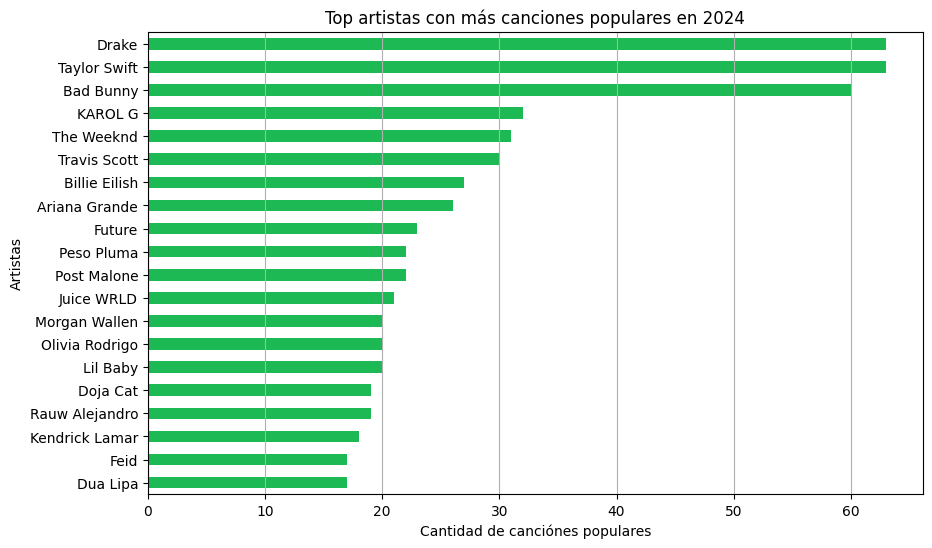

In [ ]:
#Que artistas tienen más hits?

plt.figure(figsize=(10, 6))
spotify2024['Artist'].value_counts().head(20).plot(kind='barh', color='#1db954')


plt.xlabel('Cantidad de canciónes populares')
plt.ylabel('Artistas')
plt.title('Top artistas con más canciones populares en 2024')
plt.gca().invert_yaxis() 
plt.grid(axis='x')
plt.show()

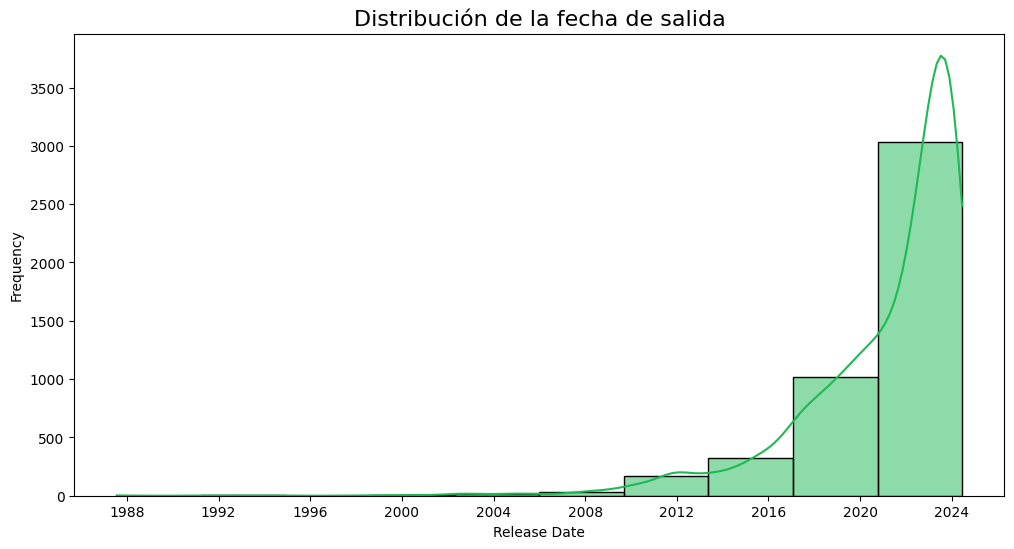

In [ ]:
plt.figure(figsize=(12, 6))
spotify2024['Release Date'] = pd.to_datetime(spotify2024['Release Date'])
sns.histplot(spotify2024['Release Date'], bins=10, kde=True, color='#1db954')
plt.title('Distribución de la fecha de salida', fontsize=16)
plt.xlabel('Release Date')
plt.ylabel('Frequency')
plt.show()

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'Explicit Track'],
      dtype='object')
Existing columns: ['Spotify Streams', 'Apple Music Playlist Count', 'Deezer Playlist Count', 'Amazon Playlist Count', 'Soundcloud Streams', 'Shazam Counts']
Missing columns: []


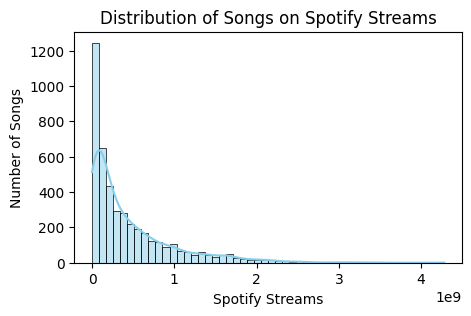

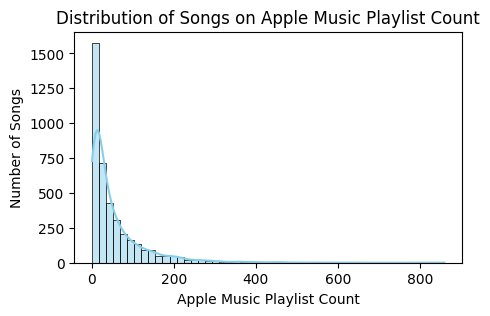

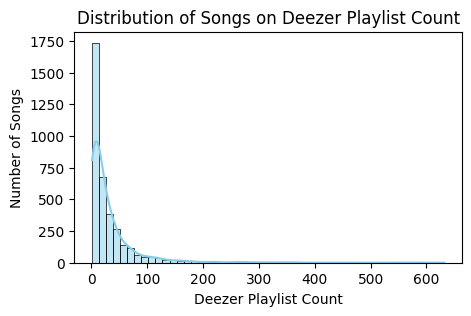

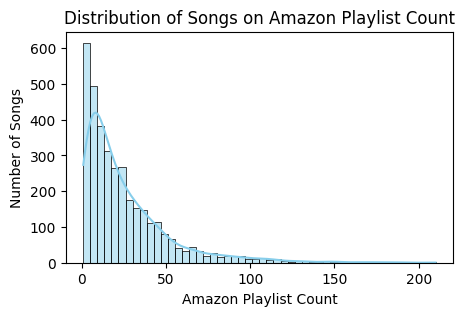

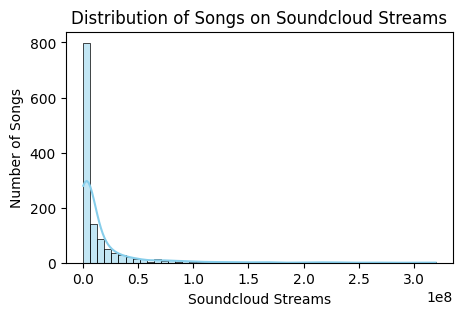

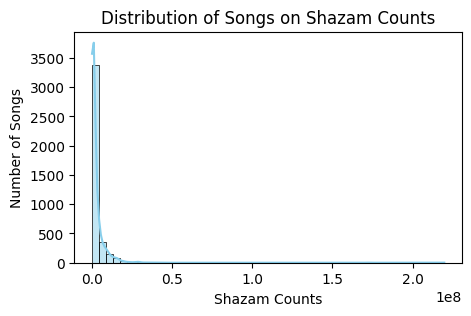

In [ ]:

# Mostrar las columnas disponibles
print(spotify2024.columns)

# Definir las columnas relevantes para las plataformas
platform_columns = [
    'Spotify Streams', 'Apple Music Playlist Count', 'Deezer Playlist Count',
    'Amazon Playlist Count', 'Soundcloud Streams', 'Shazam Counts'
]

# Verificar si las columnas existen en el DataFrame
existing_columns = [col for col in platform_columns if col in spotify2024.columns]
missing_columns = [col for col in platform_columns if col not in spotify2024.columns]

print("Existing columns:", existing_columns)
print("Missing columns:", missing_columns)

# Crear gráficos individuales para cada plataforma
for platform in existing_columns:
    plt.figure(figsize=(5, 3))
    sns.histplot(spotify2024[platform].dropna(), bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of Songs on {platform}')
    plt.xlabel(f'{platform}')
    plt.ylabel('Number of Songs')
    plt.show()


In [ ]:
# Canciones más antiguas en el dataset
antiguas = spotify2024.sort_values(by='Release Date').head(10)

antiguas[['Track', 'Artist', 'Release Date', 'Spotify Popularity']]


,Track,Artist,Release Date,Spotify Popularity
3978,Sweet Child O' Mine,Guns N' Roses,1987-07-21,80.0
4522,Smells Like Teen Spirit,Nirvana,1991-09-24,77.0
2107,All I Want for Christmas Is You,Mariah Carey,1994-01-01,60.0
4167,Beautiful Girls,Sean Kingston,1998-04-03,72.0
3729,Californication,Red Hot Chili Peppers,1999-06-08,79.0
2817,The Real Slim Shady,Eminem,2000-01-01,81.0
1806,In the End,Linkin Park,2000-10-24,82.0
4374,Over the Rainbow,Israel Kamakawiwo'ole,2001-09-25,68.0
3225,Without Me,Eminem,2002-01-01,83.0
2656,'Till I Collapse,Eminem,2002-05-26,79.0


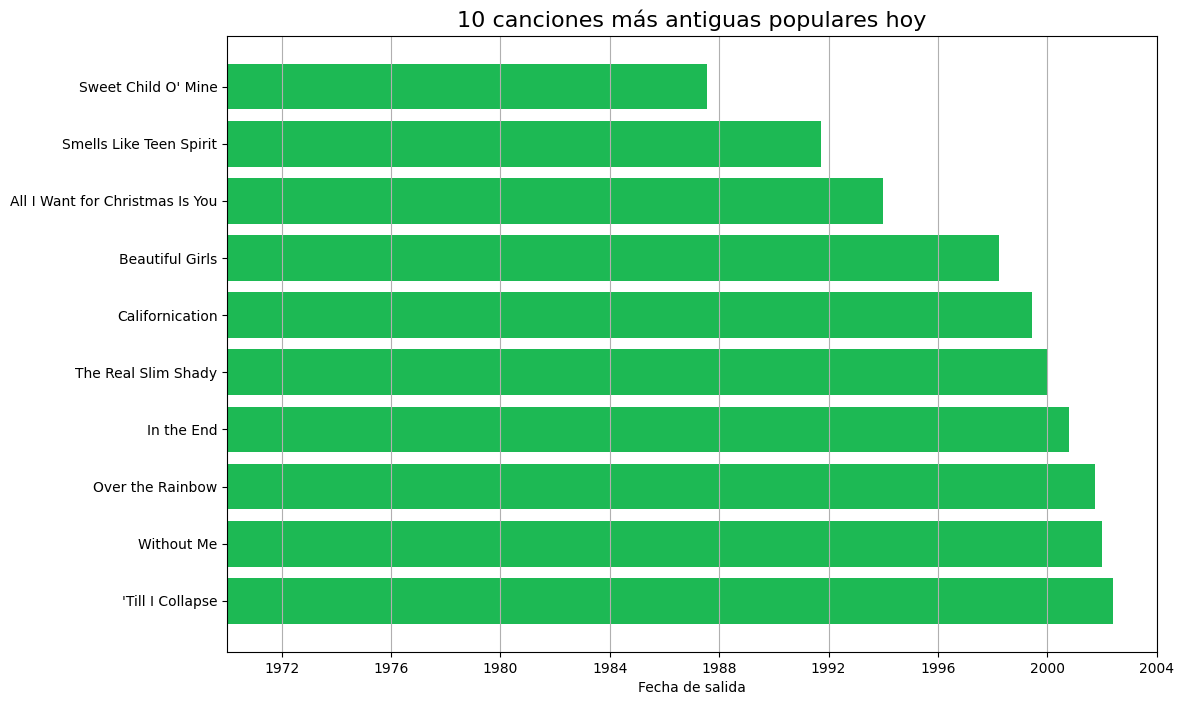

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(antiguas['Track'], antiguas['Release Date'], color='#1db954')
plt.xlabel('Fecha de salida')
plt.title('10 canciones más antiguas populares hoy', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(axis='x') 
plt.show()

In [ ]:
# Canciones más shazameadas
shazam = spotify2024.sort_values(by='Shazam Counts', ascending=False).head(10)

shazam[['Track', 'Artist', 'Shazam Counts']]


,Track,Artist,Shazam Counts
1456,"Ruqya, Pt. 3",Hani Rifai,219794543.0
1219,Every Breath You Take,Bonnie Kimmel,171902000.0
1632,i need you it's so dark,Garfy,73300614.0
39,Dance Monkey,Tones And I,44842636.0
472,Somebody That I Used To Know,Gotye,37339828.0
3560,Let Her Go,Passenger,33584600.0
544,Close,Kush & TJ,33097904.0
4390,Prayer in C - Robin Schulz Radio Edit,Lilly Wood and The Prick,30826278.0
1783,On My Grind,OG Eat,30698299.0
1297,Take Me to Church,Hozier,29306436.0


In [ ]:
spotify2024['Shazam Counts'].isnull().sum()

577

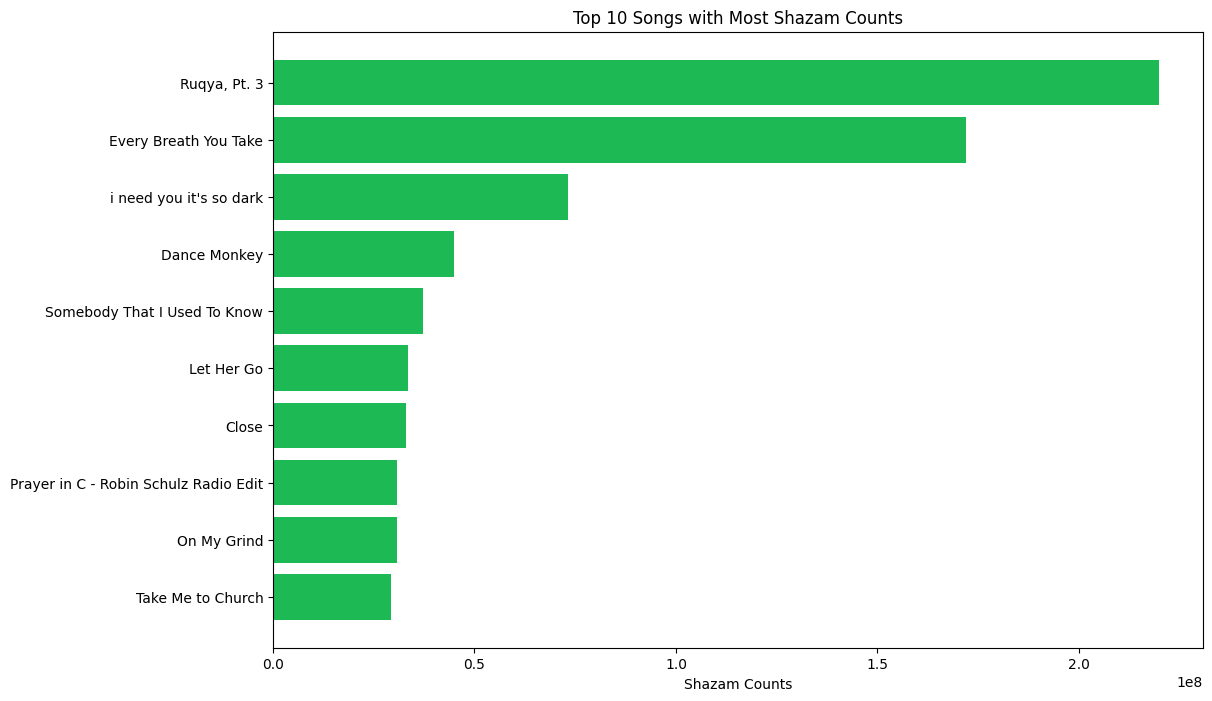

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(shazam['Track'], shazam['Shazam Counts'], color='#1db954')
plt.xlabel('Shazam Counts')
plt.title('Top 10 Songs with Most Shazam Counts')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
spotify2024.columns

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'Explicit Track'],
      dtype='object')

Una promoción vista en redes sociales como tiktok o instagram, son anuncios de playlists, claramente la acción del usuario de agregar una canción a una playlist aumenta la posibilidad de recibir más reproducciones

In [ ]:
numeric_columns = spotify2024.select_dtypes(include=np.number).columns.tolist() 


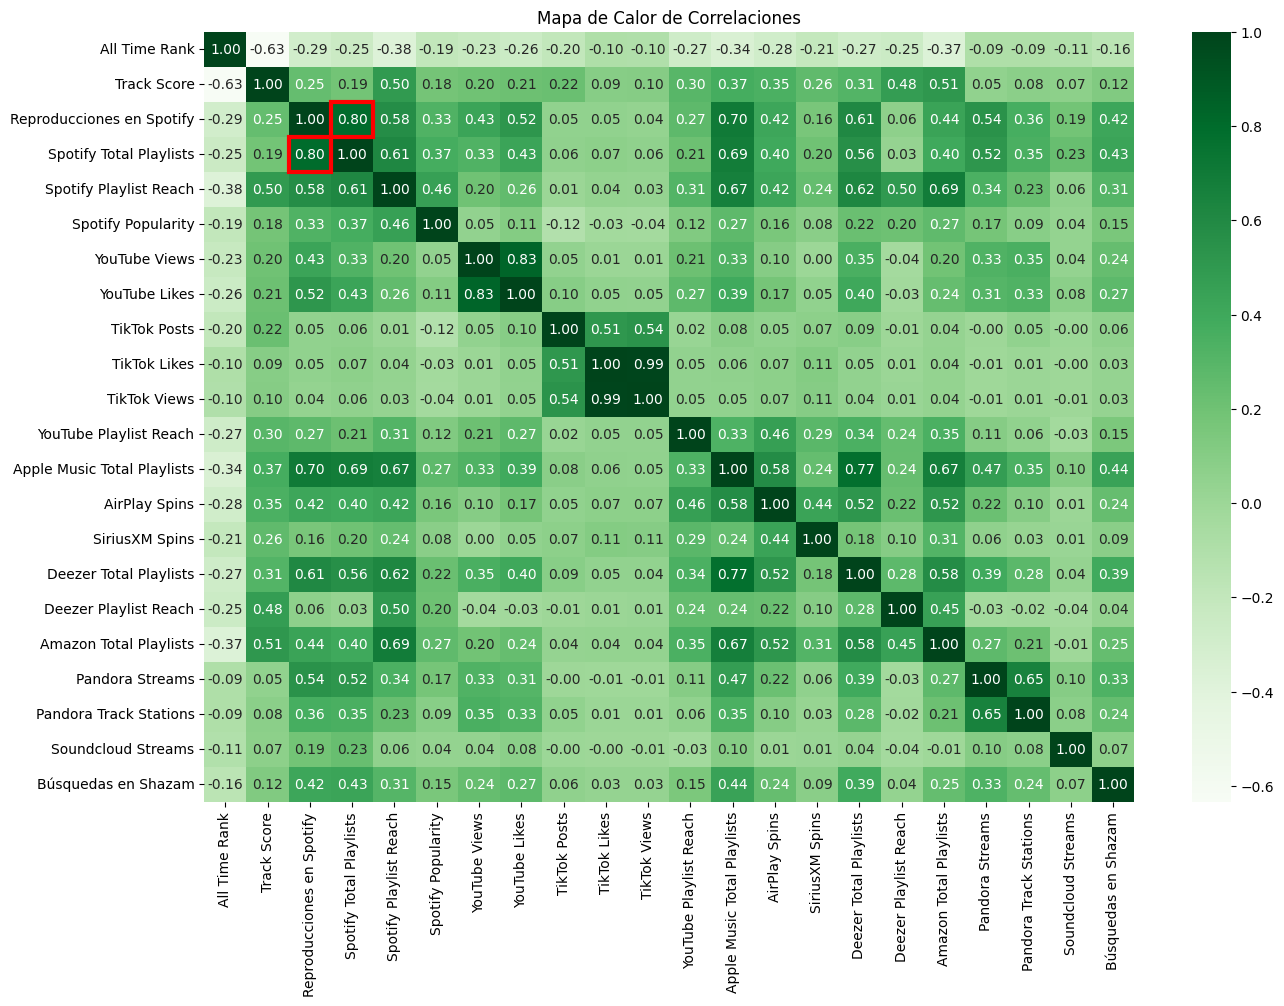

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Calcular la matriz de correlación

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones')

# Señalar lo interesante
reach_idx = spotify_selecion.columns.get_loc('Spotify Total Playlists')
plays_idx = spotify_selecion.columns.get_loc('Reproducciones en Spotify')


plt.gca().add_patch(plt.Rectangle((reach_idx, plays_idx), 1, 1, fill=False, edgecolor='red', lw=3))
plt.gca().add_patch(plt.Rectangle((plays_idx, reach_idx), 1, 1, fill=False, edgecolor='red', lw=3))

plt.show()

In [ ]:

fig1 =  px.scatter(spotify2024, x='Reproducciones en Spotify', y='Spotify Total Playlists', title='Spotify Streams vs Playlist Count')
fig1.update_layout(title='Spotify: Relación entre reproducciones y cantidad de guardados en listas de reproducción',
                   xaxis_title='Reproducciones',
                   yaxis_title='Listas de reproducción')

#Agrego las medias
mean_spotify_streams = spotify2024['Reproducciones en Spotify'].mean()
mean_spotify_playlist_count = spotify2024['Spotify Total Playlists'].mean()
fig1.add_hline(y=mean_spotify_playlist_count, line_dash="dash", line_color="red", annotation_text="Media Listas de Reproducción")
fig1.add_vline(x=mean_spotify_streams, line_dash="dash", line_color="blue", annotation_text="Media Reproducciones")
fig1.show()


In [ ]:
spotify2024['Spotify Playlist Count'].mean()

58985.16702914311

In [ ]:
#Necesita ser arreglado
spotify2024_sorted = spotify2024.sort_values(by='Spotify Popularity', ascending=False)

top_20_artists = spotify2024_sorted.head(20)

fig3 = px.bar(top_20_artists, x='Artist', y='Spotify Popularity', title='Top 20 Artists by Spotify Popularity')
fig3.show()

In [ ]:
#Aquí me fallan los outliers para poder sacar información
#fig4 = px.scatter_matrix(spotify2024[['Spotify Popularity', 'Spotify Streams', 'YouTube Views']], title='Scatter Plot Matrix')
#fig4.show()

In [ ]:
spotify2024.columns

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'Explicit Track'],
      dtype='object')

# Impacto en reded sociales ¿Influye la cantidad de views y likes en redes sociales a la popularidad de una canción en Youtube?
La cantidad de visitas en Youtube de una canción, se predice que puede aumentar con vistas y likes en Tiktok de la misma.

Error cuadrático medio: 3.2326296099452435e+17
R2 Score: 0.139743136432821


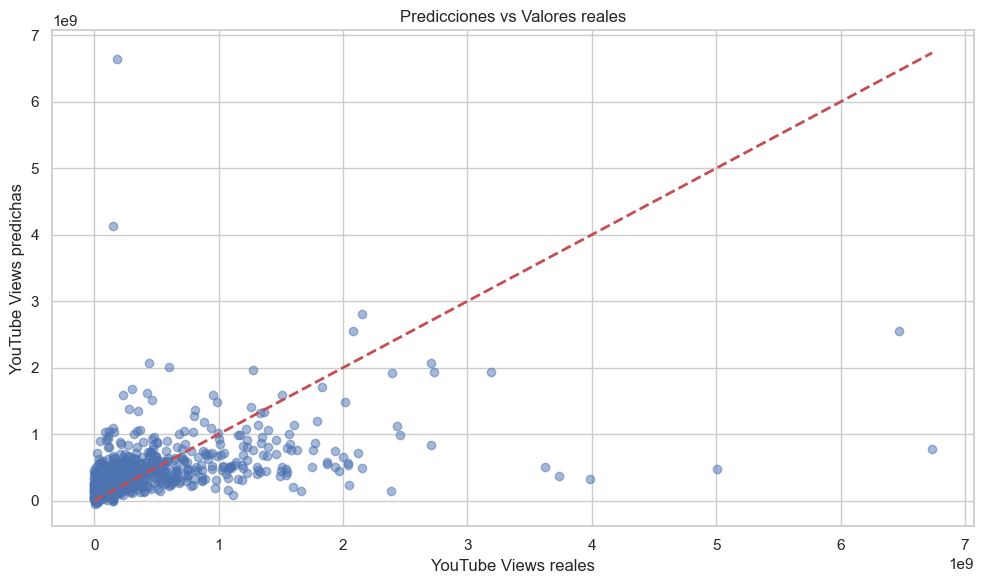

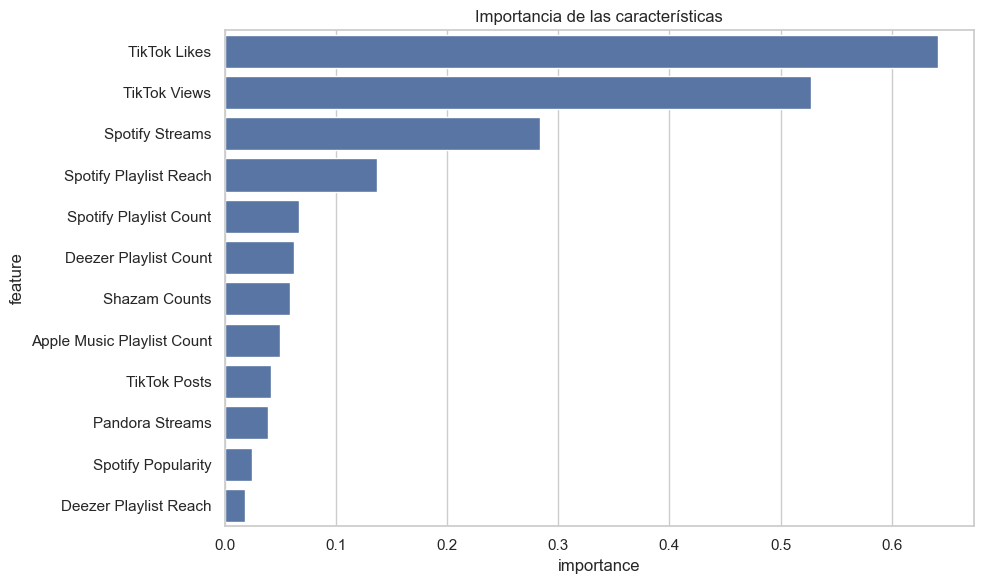

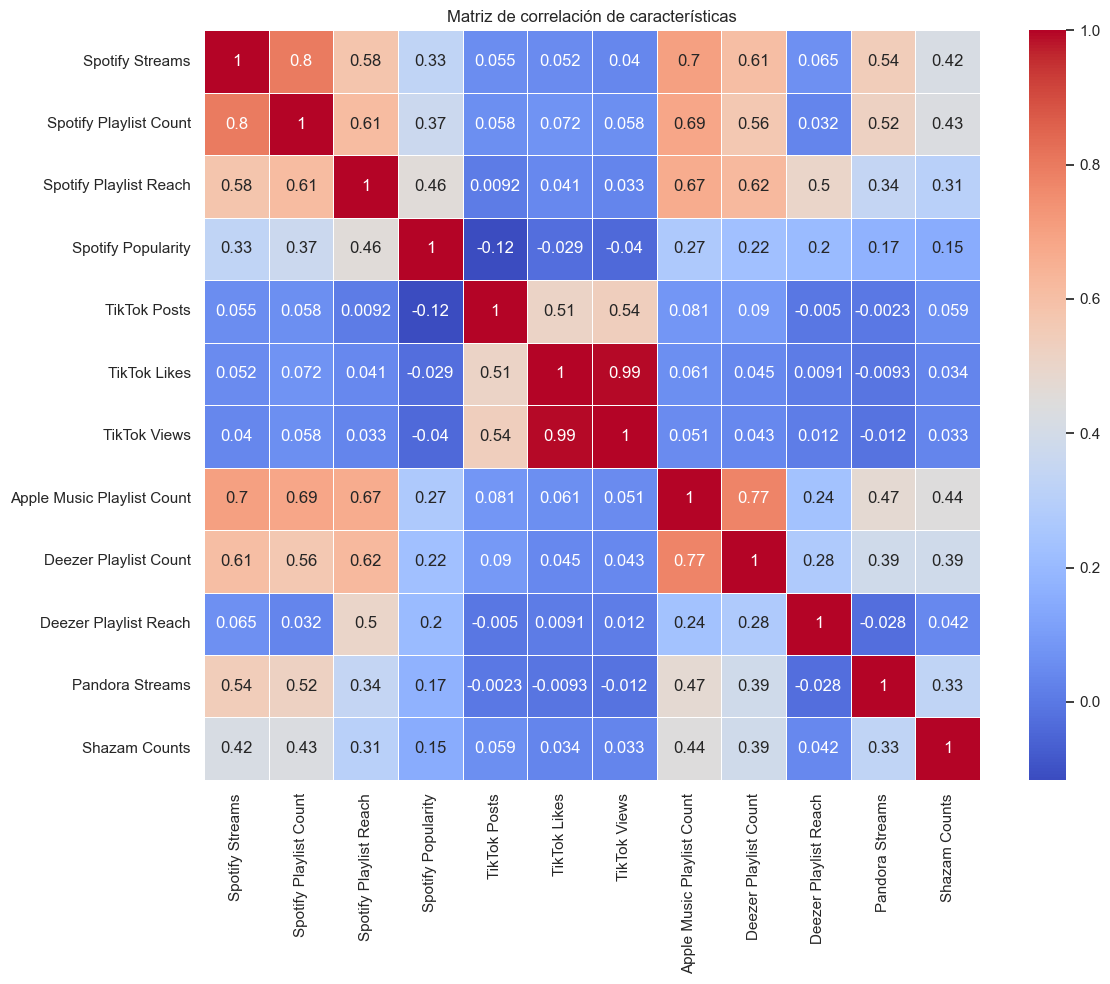


Predicciones de YouTube Views para las primeras 5 canciones del conjunto de prueba:
Canción 1: 173280552 vistas predichas
Canción 2: 28291340 vistas predichas
Canción 3: 206222818 vistas predichas
Canción 4: 460999256 vistas predichas
Canción 5: 132993199 vistas predichas


In [ ]:

spotify2024 =  pd.read_csv('/Users/aguedagambon/Bootcamp/Temario/Modulo_3/Proyecto_Spotify/spotify-2024-limpio.csv')
# Seleccionar características para la predicción
features = ['Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach',
            'Spotify Popularity', 'TikTok Posts', 'TikTok Likes', 'TikTok Views',
            'Apple Music Playlist Count', 'Deezer Playlist Count', 'Deezer Playlist Reach',
            'Pandora Streams', 'Shazam Counts']

X = spotify2024[features]
y = spotify2024['YouTube Views']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio: {mse}")
print(f"R2 Score: {r2}")

# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('YouTube Views reales')
plt.ylabel('YouTube Views predichas')
plt.title('Predicciones vs Valores reales')
plt.tight_layout()
plt.show()

# Calcular la importancia de las características
importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({'feature': features, 'importance': importance.importances_mean})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importancia de las características')
plt.tight_layout()
plt.show()

# Análisis de correlación
correlation_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación de características')
plt.tight_layout()
plt.show()

# Predicciones para nuevos datos
# Ejemplo: Predecir YouTube Views para las 5 primeras canciones del conjunto de prueba
new_predictions = model.predict(X_test_scaled[:5])
print("\nPredicciones de YouTube Views para las primeras 5 canciones del conjunto de prueba:")
for i, pred in enumerate(new_predictions):
    print(f"Canción {i+1}: {pred:.0f} vistas predichas")

In [ ]:
spotify2024.columns

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'Explicit Track', 'Success'],
      dtype='object')

In [ ]:
#Ajuste para mejorar R score, es 

df['columna_rangos'] = pd.cut(spotify2024['YouTube Views'], 
                              bins=3, 
                              labels=['poco', 'medio', 'alto'])

# Convertir los rangos a valores numéricos
spotify2024['columna_valores'] = df['columna_rangos'].map({'poco': 0, 'medio': 1, 'alto': 2})


In [ ]:
spotify2024.to_csv('/Users/aguedagambon/Bootcamp/Temario/Modulo_3/Proyecto_Spotify/spotify-2024-clean.csv', index=False)

# Modelo para las caracteristicas de las canciones explititas

In [ ]:
spotify2024.columns

Index(['Canción', 'Nombre del Álbum', 'Artista', 'Fecha de Lanzamiento',
       'ISRC', 'All Time Rank', 'Track Score', 'Reproducciones en Spotify',
       'Spotify Total Playlists', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Total Playlists', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Total Playlists', 'Deezer Playlist Reach',
       'Amazon Total Playlists', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Búsquedas en Shazam', 'Canción Explícita'],
      dtype='object')

In [ ]:
spotify2024['Spotify']

Precisión del modelo: 0.73

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.74      0.88      0.81       583
           1       0.70      0.46      0.56       337

    accuracy                           0.73       920
   macro avg       0.72      0.67      0.68       920
weighted avg       0.72      0.73      0.71       920



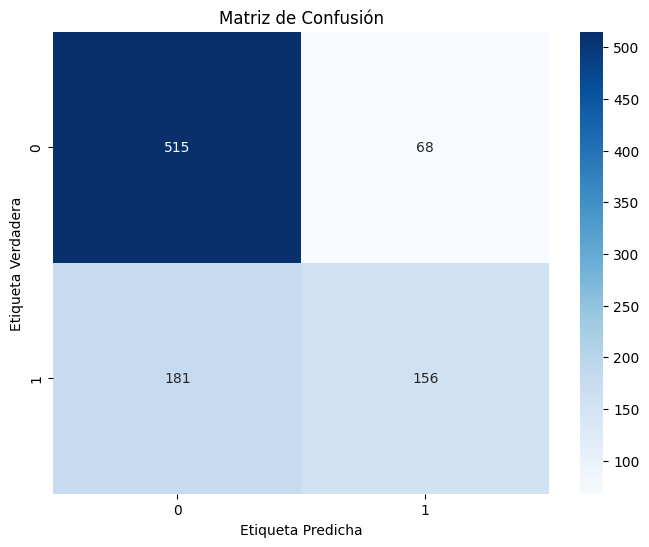

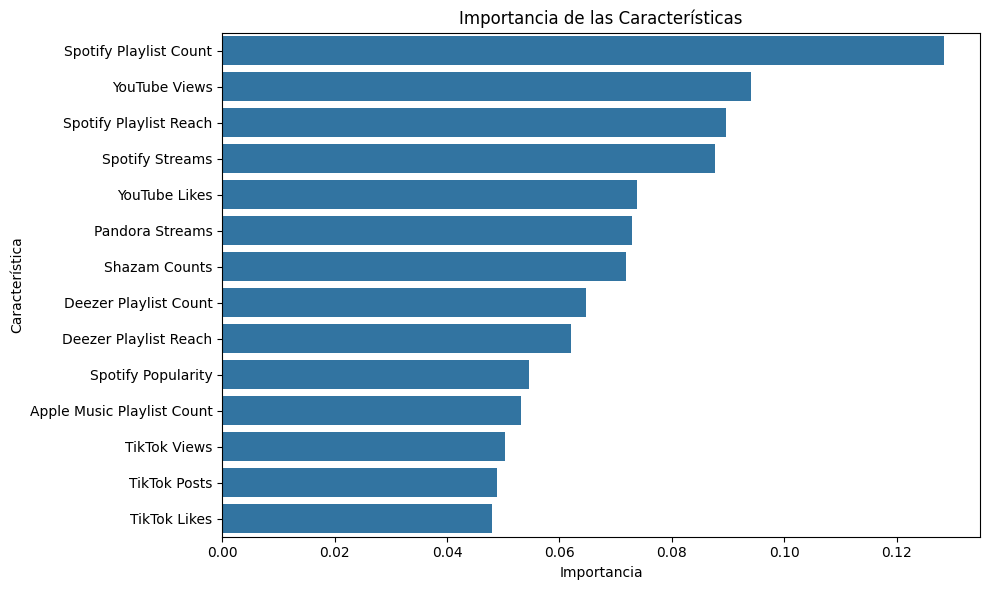


Predicciones para las primeras 5 canciones del conjunto de prueba:
Canción 1: No Explícita (Probabilidad de ser explícita: 0.44)
Canción 2: Explícita (Probabilidad de ser explícita: 0.51)
Canción 3: No Explícita (Probabilidad de ser explícita: 0.13)
Canción 4: Explícita (Probabilidad de ser explícita: 0.58)
Canción 5: No Explícita (Probabilidad de ser explícita: 0.44)


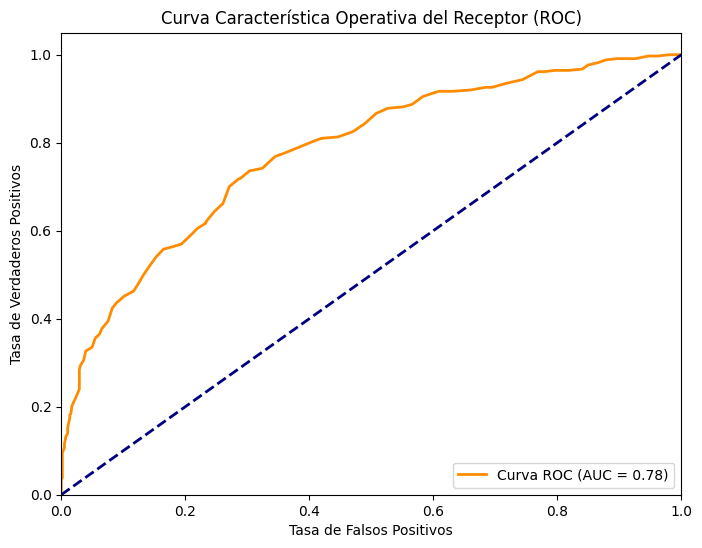

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Uso un df limpio para este modelo
df = pd.read_csv('/Users/aguedagambon/Bootcamp/Temario/Modulo_3/Proyecto_Spotify/spotify-2024-limpio.csv')


features = ['Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach',
            'Spotify Popularity', 'YouTube Views', 'YouTube Likes',
            'TikTok Posts', 'TikTok Likes', 'TikTok Views',
            'Apple Music Playlist Count', 'Deezer Playlist Count', 'Deezer Playlist Reach',
            'Pandora Streams', 'Shazam Counts']

X = df[features]
y = df['Explicit Track'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


y_pred = rf_model.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")

print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Calcular y visualizar la importancia de las características
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Predicciones con nuevos datos
# Por ejemplo, usar las primeras 5 filas del conjunto de prueba
new_predictions = rf_model.predict(X_test_scaled[:5])
new_predictions_proba = rf_model.predict_proba(X_test_scaled[:5])

print("\nPredicciones para las primeras 5 canciones del conjunto de prueba:")
for i, (pred, proba) in enumerate(zip(new_predictions, new_predictions_proba)):
    print(f"Canción {i+1}: {'Explícita' if pred else 'No Explícita'} (Probabilidad de ser explícita: {proba[1]:.2f})")

# Curva ROC
from sklearn.metrics import roc_curve, auc

y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica Operativa del Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
spotify2024.columns

Index(['Canción', 'Nombre del Álbum', 'Artista', 'Fecha de Lanzamiento',
       'ISRC', 'All Time Rank', 'Track Score', 'Reproducciones en Spotify',
       'Spotify Total Playlists', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Total Playlists', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Total Playlists', 'Deezer Playlist Reach',
       'Amazon Total Playlists', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Búsquedas en Shazam', 'Canción Explícita',
       'Success'],
      dtype='object')

# Modelo que predizca si cuando un artista saque otra canción también va a ser un éxito

In [ ]:
numeric_columns

['All Time Rank',
 'Track Score',
 'Reproducciones en Spotify',
 'Spotify Total Playlists',
 'Spotify Playlist Reach',
 'Spotify Popularity',
 'YouTube Views',
 'YouTube Likes',
 'TikTok Posts',
 'TikTok Likes',
 'TikTok Views',
 'YouTube Playlist Reach',
 'Apple Music Total Playlists',
 'AirPlay Spins',
 'SiriusXM Spins',
 'Deezer Total Playlists',
 'Deezer Playlist Reach',
 'Amazon Total Playlists',
 'Pandora Streams',
 'Pandora Track Stations',
 'Soundcloud Streams',
 'Búsquedas en Shazam']

In [47]:
spotify2024.columns

Index(['Canción', 'Nombre del Álbum', 'Artista', 'Fecha de Lanzamiento',
       'ISRC', 'All Time Rank', 'Track Score', 'Reproducciones en Spotify',
       'Spotify Total Playlists', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Total Playlists', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Total Playlists', 'Deezer Playlist Reach',
       'Amazon Total Playlists', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Búsquedas en Shazam', 'Canción Explícita',
       'Success'],
      dtype='object')

In [49]:
# Definir el éxito basado en un umbral: 500 millones de streams)
success_threshold = 500_000_000
spotify2024['Exito'] = spotify2024['Reproducciones en Spotify'] >= success_threshold

# Seleccionar características relevantes
features = ['Spotify Total Playlists', 'Spotify Playlist Reach', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Total Playlists', 'Búsquedas en Shazam', 'Soundcloud Streams']
X = spotify2024[features]
y = spotify2024['Exito']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Matriz de Confusión:")
print(cm)
print("\nReporte de Clasificación:")
print(report)


NameError: name 'confusion_matrix' is not defined

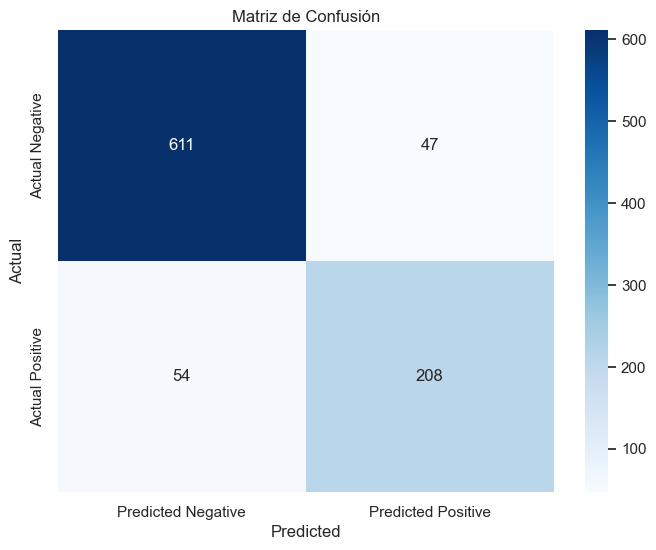

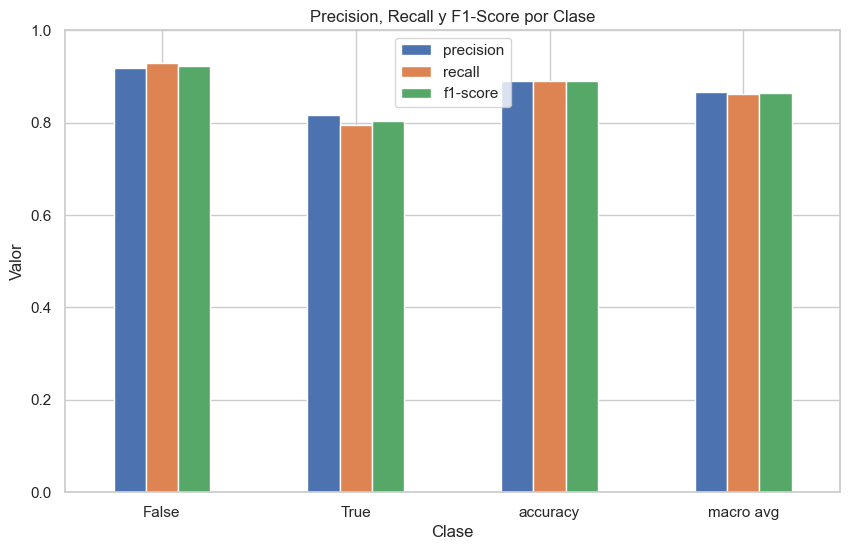

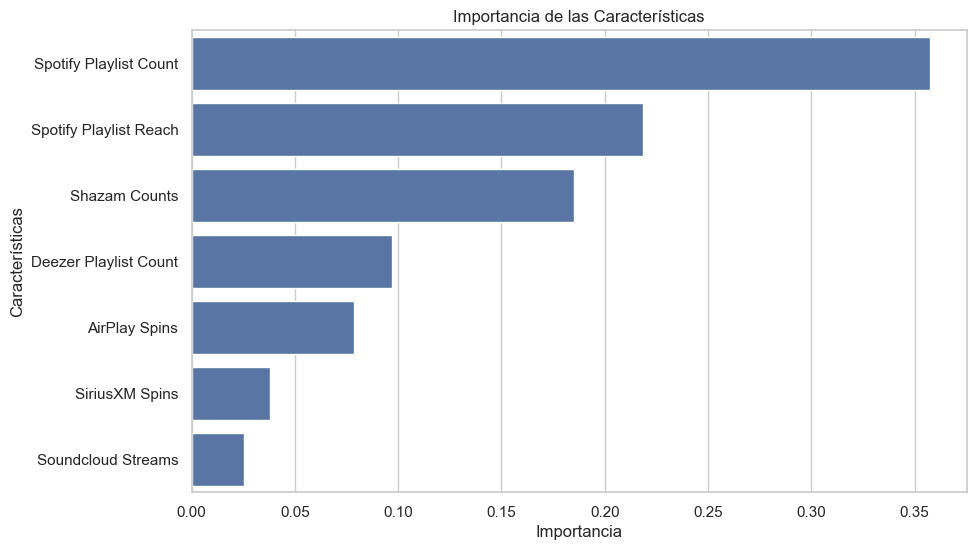

In [ ]:

# Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

#Visualización de métricas
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Gráfico de barras para Precision, Recall y F1-Score
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall y F1-Score por Clase')
plt.xlabel('Clase')
plt.ylabel('Valor')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()

# Importancias de las características
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()


# Redes neuronales

In [53]:
spotify2024.columns

Index(['Canción', 'Nombre del Álbum', 'Artista', 'Fecha de Lanzamiento',
       'ISRC', 'All Time Rank', 'Track Score', 'Reproducciones en Spotify',
       'Spotify Total Playlists', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Total Playlists', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Total Playlists', 'Deezer Playlist Reach',
       'Amazon Total Playlists', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Búsquedas en Shazam', 'Canción Explícita',
       'Success', 'Exito'],
      dtype='object')

In [58]:
spotify2024.drop(columns=['Cluster'], inplace=True)

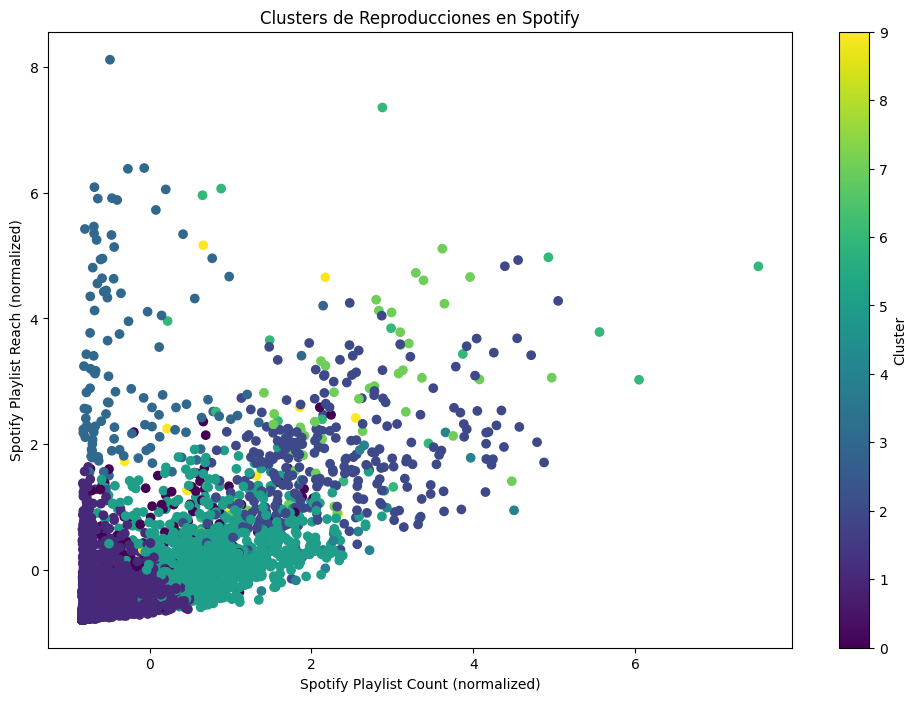

Cluster
1    2924
5     875
2     288
0     231
3     112
4      76
7      51
6      23
9      16
8       2
Name: count, dtype: int64

In [54]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



# Seleccionar características relevantes
features = ['Spotify Total Playlists', 'Spotify Playlist Reach', 'AirPlay Spins', 
            'SiriusXM Spins', 'Deezer Total Playlists', 'Búsquedas en Shazam', 'Soundcloud Streams']

X = spotify2024[features]

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
spotify2024['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualizar los resultados
plt.figure(figsize=(12, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=spotify2024['Cluster'], cmap='viridis')
plt.title('Clusters de Reproducciones en Spotify')
plt.xlabel('Spotify Playlist Count (normalized)')
plt.ylabel('Spotify Playlist Reach (normalized)')
plt.colorbar(label='Cluster')
plt.show()

# Mostrar la cantidad de datos por cluster
cluster_counts = spotify2024['Cluster'].value_counts()
cluster_counts


In [59]:
spotify2024.head()

,Canción,Nombre del Álbum,Artista,Fecha de Lanzamiento,ISRC,All Time Rank,Track Score,Reproducciones en Spotify,Spotify Total Playlists,Spotify Playlist Reach,...,Deezer Total Playlists,Deezer Playlist Reach,Amazon Total Playlists,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Búsquedas en Shazam,Canción Explícita,Success,Exito
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,2024-04-26,QM24S2402528,1,725.4,3.904709e+08,30716.0,196631588.0,...,62.0,17598718.0,114.0,18004655.0,22931.0,4818457.0,2669262.0,0,False,False
1,Not Like Us,Not Like Us,Kendrick Lamar,2024-05-04,USUG12400910,2,545.9,3.237039e+08,28113.0,174597137.0,...,67.0,10422430.0,111.0,7780028.0,28444.0,6623075.0,1118279.0,1,False,False
2,i like the way you kiss me,I like the way you kiss me,Artemas,2024-03-19,QZJ842400387,3,538.4,6.013093e+08,54331.0,211607669.0,...,136.0,36321847.0,172.0,5022621.0,5639.0,7208651.0,5285340.0,0,True,True
3,Flowers,Flowers - Single,Miley Cyrus,2023-01-12,USSM12209777,4,444.9,2.031281e+09,269802.0,136569078.0,...,264.0,24684248.0,210.0,190260277.0,203384.0,3224599.0,11822942.0,0,True,True
4,Houdini,Houdini,Eminem,2024-05-31,USUG12403398,5,423.3,1.070349e+08,7223.0,151469874.0,...,82.0,17660624.0,105.0,4493884.0,7006.0,207179.0,457017.0,1,False,False


In [63]:
import pandas as pd
import numpy as np

# Asumiendo que tu DataFrame se llama 'df'
spotify2024['Spotify Popularity Categorized'] = pd.cut(spotify2024['Spotify Popularity'], 
                                              bins=3, 
                                              labels=[0, 1, 2])

# Convertir la nueva columna a tipo int
spotify2024['Spotify Popularity Categorized'] = spotify2024['Spotify Popularity Categorized'].astype(int)

In [66]:
spotify2024.columns

Index(['Canción', 'Nombre del Álbum', 'Artista', 'Fecha de Lanzamiento',
       'ISRC', 'All Time Rank', 'Track Score', 'Reproducciones en Spotify',
       'Spotify Total Playlists', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Total Playlists', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Total Playlists', 'Deezer Playlist Reach',
       'Amazon Total Playlists', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Búsquedas en Shazam', 'Canción Explícita',
       'Success', 'Exito', 'Spotify Popularity Categorized'],
      dtype='object')

In [68]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Seleccionar las características para el modelo
features = ['Reproducciones en Spotify', 'Spotify Total Playlists', 'Spotify Playlist Reach', 
            'YouTube Views', 'YouTube Likes', 'TikTok Posts', 
            'TikTok Likes', 'TikTok Views']

X = spotify2024[features]
y = spotify2024['Spotify Popularity Categorized']  # Asumimos que esta es nuestra medida de popularidad

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construir el modelo de red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Definir early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados de la evaluación del modelo de Red Neuronal:")
print(f"Error cuadrático medio (MSE): {mse:.4f}")
print(f"Coeficiente de determinación (R2): {r2:.4f}")

# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.show()

# Ejemplo de predicción para una nueva canción
nueva_cancion = np.array([[1000000, 50, 1000000, 500000, 10000, 1000, 50000, 1000000]])
nueva_cancion_scaled = scaler.transform(nueva_cancion)
prediccion = model.predict(nueva_cancion_scaled)

print(f"\nPredicción de popularidad para la nueva canción: {prediccion[0][0]:.2f}")

# Guardar el modelo
model.save('neural_network_model.h5')
print("\nModelo guardado como 'neural_network_model.h5'")

# Visualizar la importancia de las características (aproximación)
weights = model.layers[0].get_weights()[0]
feature_importance = np.abs(weights).sum(axis=1)
feature_importance = 100 * (feature_importance / np.sum(feature_importance))

plt.figure(figsize=(10, 6))
plt.bar(features, feature_importance)
plt.title('Importancia aproximada de las características')
plt.xlabel('Características')
plt.ylabel('Importancia relativa (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Epoch 1/200


/Users/aguedagambon/Bootcamp/mi_entorno/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
